In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
import matplotlib

Using TensorFlow backend.


Initialized TensorFlow


### Steps:
1. Train $M$ networks for each dropout on training $p\in[0,1]$
2. Get mean MAE on test/train for crash/nocrash. How does it behave? **Read papers where Dropout actually works for simple datasets. Do they use scaled or unscaled dropout?**
3. Get v1, v2, v3, v4 for each of the networks
4. Compute the rank loss if the networks were ordered by these bounds
5. What should be the batch size? Does keras update crashes at each iteration? Yes

Currently, the problem is at the 2nd stage: I cannot make a network more MAE-resilient towards crashes on the Boston dataset. MNIST shows promising results if I use a smaller p_train than p_inference and batch size 100. Should I make it less? Should I make it bigger? How do I test it? Should I look at the tensorflow graph? Or should I read keras documentation?

Keras Dropout calls K.dropout which calls tf.nn.dropout, which by default creates a noise equal to the argument in shape, meaning that for 10 objects it will create 10 random dropout configurations

OK, it works for MNIST but doesn't work for the Boston dataset. Let's forget about the Boston dataset.

NEXT STEP: re-test it on bigger p, then go to steps 3, 4, 5 etc. Works for p < pinference, worse after

In [2]:
# network configuration
N = [100, 50]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, p]  + [0] * len(N)

# prob. of failure at inference
p_inf = 0.05
p_inference = get_p_arr(p_inf)

# prob. of failure at train
p_trains = np.linspace(0, 1.2 * p_inf, 10)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# see below for explanation
repetitions = 6

# number of runs for each p
runs = 10

In [3]:
def get_results(p):
    # obtaining the distribution after 10 epochs
    results = []
    
    # current prob. of failure array
    p_train = get_p_arr(p)
    
    def unravel(name, data):
        return {name + '_' + key: data[key] for key in data.keys()}
    
    for _ in tqdm(range(runs)):
        exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = p_train, KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = False,
                                      name = 'experiment_dropout', seed = None, batch_size = 100)
        
        results += [{**unravel('correct_acc', exp.get_accuracy_correct()), # test_only = True
                     **unravel('crashing_acc', exp.get_accuracy_crash(repetitions = repetitions)), # test_only = True
                     
                     **unravel('correct_mae', exp.get_mae_correct()),
                     **unravel('crashing_mae', exp.get_mae_crash(repetitions = repetitions)),
                     
                     'v2_var': np.mean(exp.get_bound_v2(exp.x_train)['std'] ** 2),
                     'v2_mean': np.mean(exp.get_bound_v2(exp.x_train)['mean']),
                     
                     'v3_var': np.mean(exp.get_bound_v3(exp.x_train)['std'] ** 2),
                     'v3_mean': np.mean(exp.get_bound_v3(exp.x_train)['mean']),
                               
                     'v4_var': np.mean(exp.get_bound_v4(exp.x_train)['std'] ** 2),
                     'v4_mean': np.mean(exp.get_bound_v4(exp.x_train)['mean']),
                     
                     'v1_infnorm_mean': np.mean(exp.get_bound_v1_infnorm(exp.x_train)['mean']),
                    }]
        
        # freeing up the memory
        K.clear_session()
        
    # list of all keys
    keys = list(results[0].keys())
    
    # return results
    return {key: [value[key] for value in results] for key in keys}

def process_results_single(results):
    for key, value in results.items():
        plt.figure()
        plt.title('%s: %.3f +- %.3f med %.3f' % (key, np.mean(value), np.std(value), np.median(value)))
        plt.hist(value)
        plt.xlabel(key)
        plt.show()

In [4]:
exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = get_p_arr(0.01), KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = False,
                                      name = 'experiment_dropout', seed = None, batch_size = 100)

In [5]:
# array of repetitions values
rs = np.arange(10)[1:]

In [6]:
# obtaining accuracy for each repetition parameter
results = [exp.get_accuracy_crash(repetitions = r) for r in tqdm(rs)]

100%|██████████| 9/9 [00:37<00:00,  5.60s/it]


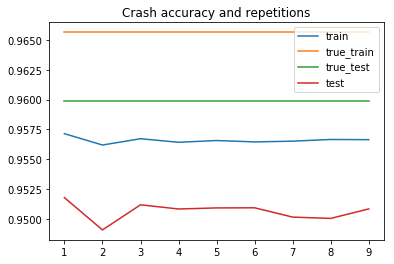

In [10]:
plt.figure()
plt.title('Crash accuracy and repetitions')
plt.plot(rs, [x['train'] for x in results], label = 'train')
plt.plot(rs, [exp.get_accuracy_correct()['train']] * len(rs), label = 'true_train')
plt.plot(rs, [exp.get_accuracy_correct()['test']] * len(rs), label = 'true_test')
plt.plot(rs, [x['test'] for x in results], label = 'test')
plt.legend()
plt.show()

In [11]:
# obtaining accuracy for each repetition parameter
results = [exp.get_mae_crash(repetitions = r) for r in tqdm(rs)]

100%|██████████| 9/9 [00:35<00:00,  5.17s/it]


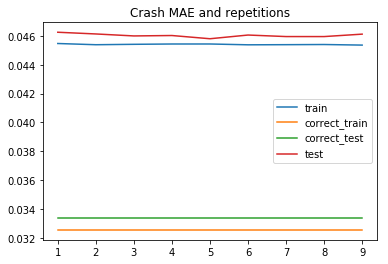

In [14]:
plt.figure()
plt.title('Crash MAE and repetitions')
plt.plot(rs, [x['train'] for x in results], label = 'train')
plt.plot(rs, [exp.get_mae_correct()['train']] * len(rs), label = 'correct_train')
plt.plot(rs, [exp.get_mae_correct()['test']] * len(rs), label = 'correct_test')
plt.plot(rs, [x['test'] for x in results], label = 'test')
plt.legend()
plt.show()

In [4]:
# 6 repetitions of the dataset is enough

In [4]:
# obtaining results
results_array = [get_results(p) for p in p_trains]

100%|██████████| 10/10 [04:29<00:00, 27.31s/it]


In [4]:
save_fn = 'ComparisonIncreasingDropoutMNIST.ipynb.pkl'
#pickle.dump(results_array, open(save_fn, 'wb'))
results_array = pickle.load(open(save_fn, 'rb'))

In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [6]:
def plot_quantity(results_array, name, axis = plt, style = '-', **kwargs):
    """ Plot mean and variance of a quantity in results_array with name """
    means = np.array([np.mean(r[name]) for r in results_array])
    stds  = [np.std(r[name]) for r in results_array]
    if name.startswith('v'):
        name = 'b' + name[1:]
    axis.plot(p_trains, means, style, label = name, **kwargs)
    axis.fill_between(p_trains, means - stds, means + stds, alpha = 0.5, **kwargs)

/localhome/xxx/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


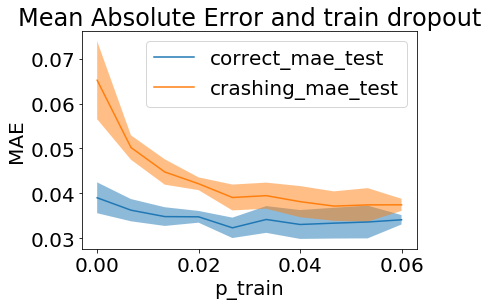

In [7]:
# it also decays for train
plt.figure()
plt.title('Mean Absolute Error and train dropout')
plot_quantity(results_array, 'correct_mae_test')
plot_quantity(results_array, 'crashing_mae_test')
#plot_quantity(results_array, 'correct_mae_train')
#plot_quantity(results_array, 'crashing_mae_train')
plt.xlabel('p_train')
plt.ylabel('MAE')
plt.legend()
plt.savefig('figures/comparison_mae_do_mnist.pdf', bbox_inches = 'tight')
plt.savefig('figures/comparison_mae_do_mnist.png', bbox_inches = 'tight')
plt.show()

<Figure size 432x288 with 0 Axes>

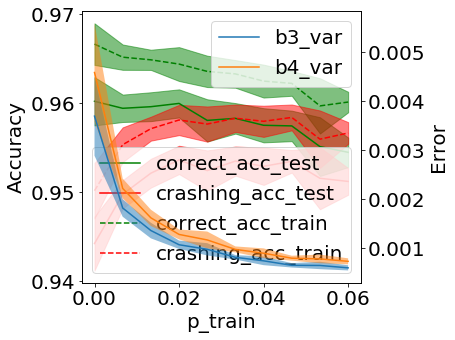

In [8]:
# it also behaves the same for train
plt.figure()

fig, ax1 = plt.subplots(figsize=(5, 5))

#plt.title('Accuracy over the dataset and train dropout')
plot_quantity(results_array, 'correct_acc_test', color = 'green', axis = ax1)
plot_quantity(results_array, 'crashing_acc_test', color = 'red', axis = ax1)
plot_quantity(results_array, 'correct_acc_train', color = 'green', style = '--',  axis = ax1)
plot_quantity(results_array, 'crashing_acc_train', color = 'red', style = '--', axis = ax1)

ax2 = ax1.twinx()
#ax3 = ax1.twinx()
#ax4 = ax1.twinx()
ax2.set_ylabel('Error', color = 'black')
plot_quantity(results_array, 'v3_var', axis = ax2)
plot_quantity(results_array, 'v4_var', axis = ax2)
ax1.set_xlabel('p_train')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.savefig('figures/comparison_acc_do_mnist.pdf', bbox_inches = 'tight')
#plt.savefig('figures/comparison_acc_do_mnist.png', bbox_inches = 'tight')
plt.show()

Choosing p_train = 0.02 results in increase in crashing accuracy by 1% but almost no decrease in correct accuracy

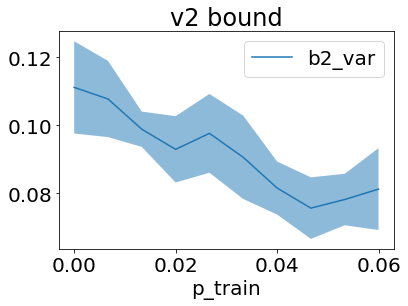

In [9]:
plt.figure()
plt.title('v2 bound')
plot_quantity(results_array, 'v2_var')
plt.xlabel('p_train')
plt.legend()
plt.show()

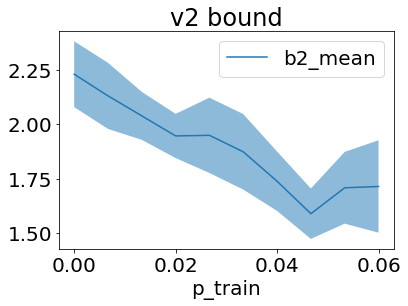

In [10]:
plt.figure()
plt.title('v2 bound')
plot_quantity(results_array, 'v2_mean')
plt.xlabel('p_train')
plt.legend()
plt.show()

In [11]:
threshold = 0.03
def get_rank_loss(results_array, key):
    def allvalues(array, key, threshold = threshold):
        """ Array of values with same key """
        return [entry[key] for i, entry in enumerate(array) if p_trains[i] <= threshold]
    
    # values for key
    values = allvalues(results_array, key)
    
    # number of p settings
    bins  = len(values)
    
    # number of networks for each p
    inbin = len(values[0])
    
    # resulting yes/no array
    result = []
    
    # loops over bind
    for bin1 in range(bins):
        for bin2 in range(bins):
            # bin1 < bin2
            if bin1 >= bin2: continue
                
            # loops inside the bin
            for elem1 in range(inbin):
                for elem2 in range(inbin):
                    # comparing v1 and v2
                    value1 = values[bin1][elem1]
                    value2 = values[bin2][elem2]
                    result += [value1 < value2]
                    
    # result: number of incorrectly ordered pairs
    value = np.mean(result)
    return min(value, 1 - value)

In [12]:
# all keys
keys = results_array[0].keys()

# all losses
losses = {key: get_rank_loss(results_array, key) for key in keys}
keys = sorted(keys, key = lambda x : losses[x])

In [13]:
# rank loss with dropout increase
pd.DataFrame([(key, losses[key]) for key in keys], columns = ['Key', 'Rank Loss'])

,Key,Rank Loss
0,v4_var,0.031
1,v3_var,0.036
2,crashing_mae_train,0.056
3,crashing_mae_test,0.056
4,crashing_acc_test,0.177
5,crashing_acc_train,0.198
6,correct_mae_test,0.220
7,correct_mae_train,0.233
8,v2_mean,0.248
9,correct_acc_train,0.317


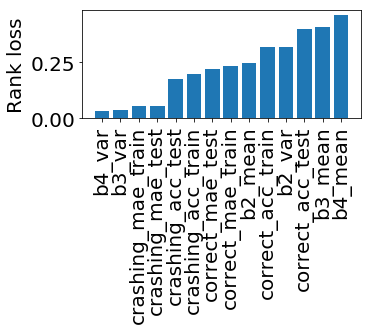

In [16]:
plt.figure(figsize=(5,2))
#plt.title('Bound comparison for dropout on train')
plt.ylabel('Rank loss')
keys_proc = ['b' + key[1:] if key.startswith('v') else key for key in keys]
plt.bar(keys_proc, [losses[x] for x in keys])
plt.xticks(rotation=90)
plt.savefig('figures/comparison_do_mnist.pdf', bbox_inches = 'tight')
#plt.savefig('figures/comparison_do_mnist.png', bbox_inches = 'tight')
plt.show()